In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('D:/data/seedlings')
list(PATH.iterdir())

[WindowsPath('D:/data/seedlings/models'),
 WindowsPath('D:/data/seedlings/tmp'),
 WindowsPath('D:/data/seedlings/train'),
 WindowsPath('D:/data/seedlings/train-224'),
 WindowsPath('D:/data/seedlings/train_masks'),
 WindowsPath('D:/data/seedlings/train_masks-224')]

In [4]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
PLANT_ID = '837ac0270'

In [7]:
list((PATH/TRAIN_DN).iterdir())[:5]

[WindowsPath('D:/data/seedlings/train/03a2ee656.png'),
 WindowsPath('D:/data/seedlings/train/1376f3b63.png'),
 WindowsPath('D:/data/seedlings/train/258b1183c.png'),
 WindowsPath('D:/data/seedlings/train/4bcdaa5e2.png'),
 WindowsPath('D:/data/seedlings/train/4f83143e1.png')]

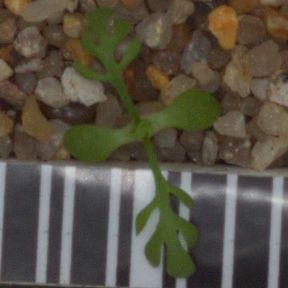

In [8]:
Image.open(PATH/TRAIN_DN/f'{PLANT_ID}.png')

In [9]:
list((PATH/MASKS_DN).iterdir())[:5]

[WindowsPath('D:/data/seedlings/train_masks/03a2ee656_mask.png'),
 WindowsPath('D:/data/seedlings/train_masks/1376f3b63_mask.png'),
 WindowsPath('D:/data/seedlings/train_masks/258b1183c_mask.png'),
 WindowsPath('D:/data/seedlings/train_masks/4bcdaa5e2_mask.png'),
 WindowsPath('D:/data/seedlings/train_masks/4f83143e1_mask.png')]

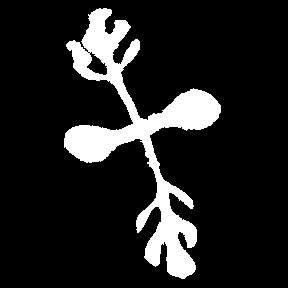

In [10]:
Image.open(PATH/MASKS_DN/f'{PLANT_ID}_mask.png')

### Resize and convert

In [11]:
(PATH/'train_masks-224').mkdir(exist_ok=True)

In [12]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks-224'/f'{fn}')

In [13]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [14]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save(fn)

files = list((PATH/'train_masks-224').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [15]:
(PATH/'train-224').mkdir(exist_ok=True)

In [16]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-224'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [17]:
TRAIN_DN = 'train-224'
MASKS_DN = 'train_masks-224'
sz = 224
bs = 2

In [18]:
ims = [open_image(PATH/TRAIN_DN/f'{PLANT_ID}.png')]
im_masks = [open_image(PATH/MASKS_DN/f'{PLANT_ID}_mask.png')]

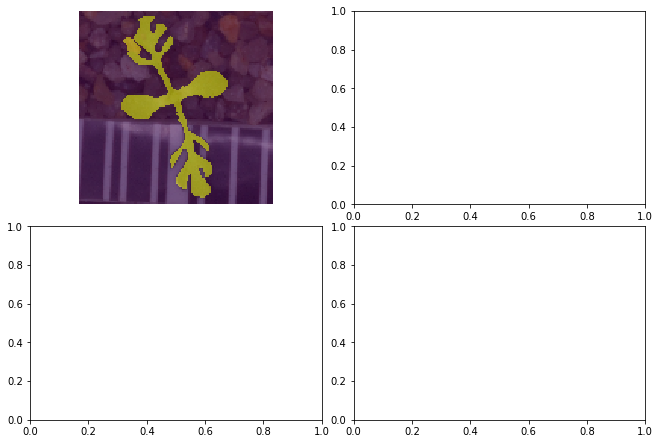

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
    break
plt.tight_layout(pad=0.1)

In [20]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [21]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

In [22]:
len(x_names)

20

In [23]:
val_idxs = [19]
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
print(len(val_x),len(trn_x))
print(len(val_y))

1 19
1


In [24]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [25]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get_n(self): return len(self.y)

In [26]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [27]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

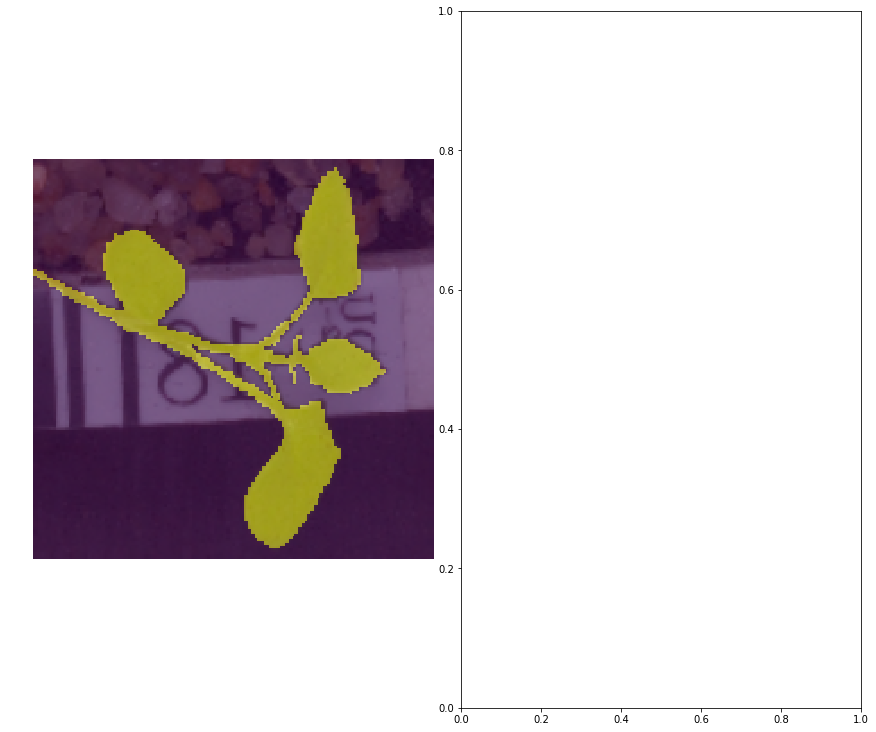

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
    break
plt.tight_layout(pad=0.1)

## Model

In [29]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [30]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [31]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [32]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.5)

In [33]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      1.574958   1559468.75 0.574019  



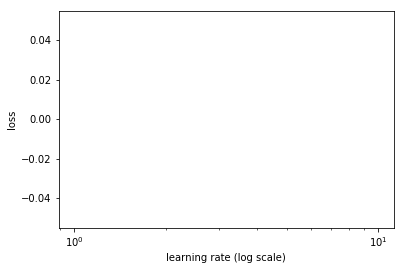

In [34]:
learn.lr_find()
learn.sched.plot()

In [35]:
lr=4e-2

In [36]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.637448   4.658736   0.395687  
    1      0.546435   4.991513   0.48864                                                                               
    2      0.457755   1.622356   0.677993                                                                              
    3      0.431111   0.716986   0.721739                                                                              
    4      0.412793   0.772447   0.691924                                                                              



[0.7724474, 0.6919244527816772]

In [37]:
learn.save('tmp')

In [38]:
learn.load('tmp')

In [39]:
py,ay = learn.predict_with_targs()

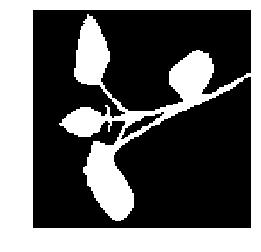

In [40]:
show_img(ay[0]);

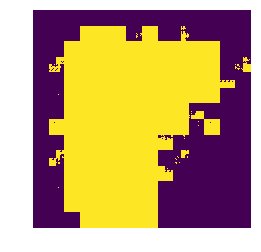

In [41]:
show_img(py[0][0]>0);

In [42]:
learn.unfreeze()

In [43]:
learn.bn_freeze(True)

In [44]:
lrs = np.array([lr/100,lr/10,lr])/4

In [45]:
learn.fit(lrs,100,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=4000), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.386342   0.39004    0.841398  
    1      0.414766   0.439873   0.824219                                                                              
    2      0.450608   0.463977   0.824219                                                                              
    3      0.4621     0.463026   0.824219                                                                              
    4      0.477916   0.466063   0.824219                                                                              
    5      0.484951   0.48608    0.824219                                                                              
    6      0.501776   0.464235   0.824219                                                                              
    7      0.504515   0.484256   0.824219                                                                           

    67     0.181425   0.206339   0.904596                                                                              
    68     0.170408   0.205286   0.907605                                                                              
    69     0.172832   0.206098   0.910196                                                                              
    70     0.162311   0.2048     0.910057                                                                              
    71     0.152383   0.205245   0.907246                                                                              
    72     0.178661   0.20171    0.903081                                                                              
    73     0.168885   0.2016     0.907386                                                                              
    74     0.171005   0.195238   0.910734                                                                              
    75     0.161662   0.194724   0.91119

   135     0.116934   0.256      0.907506                                                                              
   136     0.114098   0.253771   0.908422                                                                              
   137     0.110963   0.23759    0.90896                                                                               
   138     0.107016   0.237733   0.912349                                                                              
   139     0.137438   0.243756   0.909678                                                                              
   140     0.142976   0.222409   0.909758                                                                              
   141     0.13523    0.24209    0.909558                                                                              
   142     0.131621   0.250409   0.90348                                                                               
   143     0.143908   0.245247   0.90308

   203     0.114261   0.232292   0.906011                                                                              
   204     0.10701    0.243269   0.895468                                                                              
   205     0.104046   0.248173   0.8977                                                                                
   206     0.112868   0.237245   0.898497                                                                              
   207     0.110612   0.240536   0.896843                                                                              
   208     0.111005   0.228372   0.902463                                                                              
   209     0.105067   0.263248   0.903898                                                                              
   210     0.109307   0.227794   0.901686                                                                              
   211     0.121432   0.235889   0.89188

   271     0.096132   0.236932   0.904436                                                                              
   272     0.090612   0.24052    0.905831                                                                              
   273     0.085932   0.249632   0.907007                                                                              
   274     0.08009    0.25772    0.903839                                                                              
   275     0.074287   0.261348   0.905592                                                                              
   276     0.075341   0.260777   0.905433                                                                              
   277     0.089104   0.249338   0.905154                                                                              
   278     0.093502   0.24093    0.904157                                                                              
   279     0.102016   0.237032   0.90373

   339     0.080305   0.294382   0.897999                                                                              
   340     0.076915   0.285925   0.898497                                                                              
   341     0.076515   0.284681   0.894452                                                                              
   342     0.078347   0.261093   0.898537                                                                              
   343     0.09019    0.24406    0.902922                                                                              
   344     0.086228   0.266687   0.902503                                                                              
   345     0.09822    0.270073   0.888473                                                                              
   346     0.099787   0.249522   0.894711                                                                              
   347     0.094727   0.258792   0.89148

   407     0.136966   0.260618   0.874342                                                                              
   408     0.129563   0.257323   0.896385                                                                              
   409     0.11885    0.277783   0.897979                                                                              
   410     0.109423   0.295542   0.8978                                                                                
   411     0.102983   0.277063   0.893595                                                                              
   412     0.093083   0.279419   0.90061                                                                               
   413     0.089897   0.269343   0.895368                                                                              
   414     0.088511   0.272824   0.890944                                                                              
   415     0.103148   0.305518   0.84125

   475     0.100946   0.289821   0.891801                                                                              
   476     0.0941     0.2851     0.893754                                                                              
   477     0.089266   0.283181   0.895588                                                                              
   478     0.087027   0.283544   0.895667                                                                              
   479     0.087296   0.284053   0.895886                                                                              
   480     0.082631   0.287654   0.896783                                                                              
   481     0.086902   0.283506   0.896704                                                                              
   482     0.084804   0.271765   0.892997                                                                              
   483     0.079067   0.29428    0.89487

   543     0.132785   0.275048   0.891263                                                                              
   544     0.122679   0.290876   0.892558                                                                              
   545     0.112712   0.30441    0.894591                                                                              
   546     0.119079   0.273204   0.890027                                                                              
   547     0.119129   0.261851   0.88634                                                                               
   548     0.110625   0.269697   0.887078                                                                              
   549     0.104762   0.283398   0.889389                                                                              
   550     0.103938   0.281416   0.889688                                                                              
   551     0.108683   0.273684   0.88942

   611     0.087242   0.263163   0.89198                                                                               
   612     0.089545   0.283499   0.886101                                                                              
   613     0.090975   0.253571   0.895069                                                                              
   614     0.106761   0.258037   0.879544                                                                              
   615     0.116885   0.301748   0.874243                                                                              
   616     0.110231   0.309617   0.878667                                                                              
   617     0.10445    0.318048   0.890625                                                                              
   618     0.110581   0.292297   0.881956                                                                              
   619     0.105881   0.28724    0.88034

   679     0.084318   0.263439   0.891183                                                                              
   680     0.08239    0.265459   0.890545                                                                              
   681     0.078241   0.279319   0.888572                                                                              
   682     0.100456   0.279761   0.890485                                                                              
   683     0.10251    0.286641   0.880899                                                                              
   684     0.100201   0.392542   0.875598                                                                              
   685     0.095153   0.340473   0.875219                                                                              
   686     0.110509   0.244072   0.886679                                                                              
   687     0.117526   0.255243   0.87944

   747     0.085261   0.264047   0.894491                                                                              
   748     0.079974   0.265806   0.896385                                                                              
   749     0.073839   0.2765     0.895428                                                                              
   750     0.076331   0.276124   0.896803                                                                              
   751     0.069603   0.273371   0.89772                                                                               
   752     0.06848    0.270807   0.897919                                                                              
   753     0.064739   0.279734   0.894013                                                                              
   754     0.060989   0.287713   0.892817                                                                              
   755     0.05919    0.288289   0.89255

   815     0.082864   0.261139   0.897321                                                                              
   816     0.089409   0.256119   0.902902                                                                              
   817     0.091241   0.250811   0.903839                                                                              
   818     0.085988   0.272918   0.898557                                                                              
   819     0.107045   0.248417   0.899673                                                                              
   820     0.102289   0.244755   0.899872                                                                              
   821     0.096704   0.25916    0.895468                                                                              
   822     0.097738   0.258212   0.900072                                                                              
   823     0.090972   0.25714    0.90527

   883     0.059332   0.29806    0.884208                                                                              
   884     0.05724    0.28134    0.894611                                                                              
   885     0.06866    0.258555   0.896504                                                                              
   886     0.066628   0.291462   0.879325                                                                              
   887     0.069469   0.259824   0.897122                                                                              
   888     0.076055   0.260821   0.89483                                                                               
   889     0.083895   0.241966   0.902703                                                                              
   890     0.090424   0.244973   0.896146                                                                              
   891     0.089906   0.247391   0.89548

   951     0.10353    0.242207   0.903101                                                                              
   952     0.095433   0.244824   0.902742                                                                              
   953     0.090699   0.249981   0.900331                                                                              
   954     0.08863    0.252472   0.899773                                                                              
   955     0.09328    0.252697   0.901028                                                                              
   956     0.096306   0.251546   0.901327                                                                              
   957     0.091351   0.251688   0.901726                                                                              
   958     0.084016   0.252608   0.90047                                                                               
   959     0.079701   0.253031   0.90015

   1019    0.092156   0.275302   0.884746                                                                              
   1020    0.093094   0.281795   0.884766                                                                              
   1021    0.089637   0.311517   0.877531                                                                              
   1022    0.100574   0.25057    0.901487                                                                              
   1023    0.09678    0.266547   0.903061                                                                              
   1024    0.091139   0.306252   0.902125                                                                              
   1025    0.090953   0.330982   0.887974                                                                              
   1026    0.092181   0.286984   0.893076                                                                              
   1027    0.084011   0.299187   0.89126

   1087    0.106492   0.285253   0.88074                                                                               
   1088    0.103169   0.255763   0.899633                                                                              
   1089    0.101566   0.259805   0.89499                                                                               
   1090    0.098243   0.266282   0.890226                                                                              
   1091    0.092972   0.316345   0.873505                                                                              
   1092    0.089731   0.294356   0.887078                                                                              
   1093    0.087982   0.277666   0.889409                                                                              
   1094    0.080363   0.286231   0.885025                                                                              
   1095    0.078121   0.265176   0.89660

   1155    0.086286   0.296585   0.880959                                                                              
   1156    0.082181   0.311088   0.875538                                                                              
   1157    0.078234   0.318884   0.873605                                                                              
   1158    0.08249    0.314268   0.875359                                                                              
   1159    0.08712    0.307417   0.87791                                                                               
   1160    0.082418   0.310638   0.876355                                                                              
   1161    0.082115   0.324044   0.871353                                                                              
   1162    0.089118   0.248591   0.900092                                                                              
   1163    0.088045   0.264121   0.89913

   1223    0.069413   0.390718   0.875478                                                                              
   1224    0.07162    0.286274   0.893056                                                                              
   1225    0.08041    0.253388   0.895867                                                                              
   1226    0.085348   0.250132   0.895966                                                                              
   1227    0.085023   0.25278    0.89489                                                                               
   1228    0.079981   0.261931   0.894671                                                                              
   1229    0.083431   0.264639   0.894172                                                                              
   1230    0.080076   0.27375    0.891522                                                                              
   1231    0.076112   0.283201   0.88988

   1291    0.066143   0.325402   0.885942                                                                              
   1292    0.068149   0.296679   0.888353                                                                              
   1293    0.067264   0.272205   0.898816                                                                              
   1294    0.063811   0.284392   0.898776                                                                              
   1295    0.073217   0.263973   0.900132                                                                              
   1296    0.072849   0.250506   0.896464                                                                              
   1297    0.067904   0.259716   0.898836                                                                              
   1298    0.08586    0.239858   0.899892                                                                              
   1299    0.082269   0.247679   0.89895

   1359    0.074606   0.293829   0.881378                                                                              
   1360    0.069175   0.296859   0.88064                                                                               
   1361    0.076321   0.270195   0.893754                                                                              
   1362    0.074266   0.269394   0.895169                                                                              
   1363    0.076259   0.261298   0.895807                                                                              
   1364    0.07312    0.287204   0.887217                                                                              
   1365    0.069838   0.370068   0.873465                                                                              
   1366    0.079172   0.260532   0.903261                                                                              
   1367    0.079187   0.293938   0.89929

   1427    0.081235   0.274321   0.891741                                                                              
   1428    0.074941   0.291621   0.89218                                                                               
   1429    0.068573   0.312685   0.887934                                                                              
   1430    0.065155   0.335422   0.884526                                                                              
   1431    0.062905   0.332243   0.885224                                                                              
   1432    0.063948   0.31383    0.887018                                                                              
   1433    0.083379   0.274165   0.893276                                                                              
   1434    0.084594   0.253323   0.89764                                                                               
   1435    0.089772   0.251294   0.89825

   1495    0.066005   0.382967   0.882872                                                                              
   1496    0.059679   0.388356   0.886619                                                                              
   1497    0.061181   0.363491   0.876694                                                                              
   1498    0.073747   0.255398   0.90051                                                                               
   1499    0.071974   0.246145   0.904855                                                                              
   1500    0.070988   0.249025   0.904616                                                                              
   1501    0.067113   0.275389   0.901846                                                                              
   1502    0.089067   0.26411    0.889768                                                                              
   1503    0.084575   0.257647   0.88923

   1563    0.067911   0.297921   0.893774                                                                              
   1564    0.062563   0.314337   0.887257                                                                              
   1565    0.066303   0.26527    0.905692                                                                              
   1566    0.065382   0.266337   0.905991                                                                              
   1567    0.067403   0.257486   0.904735                                                                              
   1568    0.074624   0.244521   0.907665                                                                              
   1569    0.075739   0.246201   0.907685                                                                              
   1570    0.075871   0.258582   0.89778                                                                               
   1571    0.071266   0.291493   0.88835

   1631    0.071817   0.248699   0.904317                                                                              
   1632    0.075697   0.245483   0.905393                                                                              
   1633    0.069605   0.24226    0.907605                                                                              
   1634    0.071411   0.244163   0.907824                                                                              
   1635    0.067964   0.251784   0.904974                                                                              
   1636    0.074791   0.251554   0.904915                                                                              
   1637    0.070345   0.256066   0.903699                                                                              
   1638    0.066239   0.262676   0.901706                                                                              
   1639    0.076826   0.261634   0.90144

   1699    0.077373   0.277228   0.893794                                                                              
   1700    0.081139   0.251698   0.900191                                                                              
   1701    0.078543   0.262325   0.897361                                                                              
   1702    0.082046   0.247577   0.902304                                                                              
   1703    0.079396   0.247931   0.902782                                                                              
   1704    0.08019    0.251374   0.903679                                                                              
   1705    0.075497   0.266146   0.900789                                                                              
   1706    0.071246   0.283223   0.896624                                                                              
   1707    0.068137   0.283562   0.89415

   1767    0.089385   0.279005   0.894292                                                                              
   1768    0.084673   0.345009   0.890127                                                                              
   1769    0.081959   0.317707   0.884407                                                                              
   1770    0.074955   0.288668   0.89786                                                                               
   1771    0.082138   0.246787   0.901048                                                                              
   1772    0.086294   0.245709   0.896026                                                                              
   1773    0.081543   0.287762   0.891283                                                                              
   1774    0.076994   0.308706   0.887137                                                                              
   1775    0.069976   0.34889    0.88903

   1835    0.087981   0.259569   0.895348                                                                              
   1836    0.090139   0.254181   0.895667                                                                              
   1837    0.082541   0.253185   0.896165                                                                              
   1838    0.080533   0.253815   0.896006                                                                              
   1839    0.084816   0.254213   0.896185                                                                              
   1840    0.090474   0.249036   0.896524                                                                              
   1841    0.09473    0.239421   0.901088                                                                              
   1842    0.089815   0.247367   0.898776                                                                              
   1843    0.094613   0.258848   0.90212

   1903    0.071834   0.301746   0.89479                                                                               
   1904    0.066435   0.313502   0.893276                                                                              
   1905    0.073631   0.27048    0.899035                                                                              
   1906    0.073826   0.259167   0.897919                                                                              
   1907    0.070418   0.266959   0.900191                                                                              
   1908    0.066743   0.280883   0.89778                                                                               
   1909    0.072382   0.257342   0.901925                                                                              
   1910    0.069571   0.255982   0.90057                                                                               
   1911    0.080607   0.249142   0.89971

   1971    0.065507   0.2959     0.876515                                                                              
   1972    0.062442   0.24597    0.90061                                                                               
   1973    0.080759   0.241887   0.899374                                                                              
   1974    0.084924   0.240159   0.898158                                                                              
   1975    0.090548   0.240446   0.886739                                                                              
   1976    0.088282   0.28573    0.883371                                                                              
   1977    0.080508   0.279504   0.887636                                                                              
   1978    0.075543   0.431186   0.868722                                                                              
   1979    0.085019   0.266882   0.89293

   2039    0.068069   0.263216   0.899095                                                                              
   2040    0.067686   0.264227   0.899015                                                                              
   2041    0.062307   0.263217   0.901706                                                                              
   2042    0.05783    0.291551   0.89786                                                                               
   2043    0.06201    0.282535   0.893136                                                                              
   2044    0.058652   0.279023   0.897501                                                                              
   2045    0.060035   0.270638   0.901487                                                                              
   2046    0.059161   0.266954   0.902144                                                                              
   2047    0.056101   0.29042    0.90288

   2107    0.075528   0.324377   0.882593                                                                              
   2108    0.07439    0.325502   0.883072                                                                              
   2109    0.084537   0.291378   0.889748                                                                              
   2110    0.083306   0.279347   0.896325                                                                              
   2111    0.082176   0.264287   0.899294                                                                              
   2112    0.076535   0.266016   0.899374                                                                              
   2113    0.075949   0.268108   0.898537                                                                              
   2114    0.071464   0.277286   0.900112                                                                              
   2115    0.066684   0.284528   0.89941

   2175    0.112424   0.305108   0.873426                                                                              
   2176    0.104567   0.360972   0.871333                                                                              
   2177    0.103872   0.294125   0.893933                                                                              
   2178    0.105774   0.344107   0.873844                                                                              
   2179    0.098266   0.313774   0.876674                                                                              
   2180    0.0912     0.308101   0.874203                                                                              
   2181    0.083484   0.3211     0.874103                                                                              
   2182    0.081973   0.313433   0.876794                                                                              
   2183    0.088929   0.291133   0.87952

   2243    0.071602   0.309798   0.880022                                                                              
   2244    0.072364   0.273375   0.893096                                                                              
   2245    0.070227   0.309485   0.881597                                                                              
   2246    0.068876   0.318802   0.881138                                                                              
   2247    0.086763   0.266343   0.880242                                                                              
   2248    0.087131   0.262028   0.886818                                                                              
   2249    0.086971   0.303018   0.881457                                                                              
   2250    0.084562   0.331322   0.870436                                                                              
   2251    0.086423   0.271732   0.88841

   2311    0.064549   0.281548   0.897003                                                                              
   2312    0.063683   0.284889   0.893754                                                                              
   2313    0.062431   0.28614    0.892259                                                                              
   2314    0.058143   0.28673    0.892897                                                                              
   2315    0.057562   0.293434   0.891163                                                                              
   2316    0.055395   0.302557   0.888552                                                                              
   2317    0.0617     0.30225    0.887715                                                                              
   2318    0.058084   0.304389   0.886001                                                                              
   2319    0.059265   0.304761   0.88552

   2379    0.083436   0.287153   0.886958                                                                              
   2380    0.083807   0.284335   0.885523                                                                              
   2381    0.077555   0.288746   0.8865                                                                                
   2382    0.082395   0.280314   0.888512                                                                              
   2383    0.082166   0.283453   0.887436                                                                              
   2384    0.078947   0.28954    0.887994                                                                              
   2385    0.071236   0.296166   0.888194                                                                              
   2386    0.06689    0.322527   0.886181                                                                              
   2387    0.070046   0.31785    0.88311

   2447    0.081009   0.280332   0.895308                                                                              
   2448    0.077605   0.288574   0.891841                                                                              
   2449    0.089303   0.249965   0.895787                                                                              
   2450    0.093666   0.255349   0.895588                                                                              
   2451    0.094206   0.255161   0.897082                                                                              
   2452    0.08831    0.279027   0.893515                                                                              
   2453    0.082327   0.312738   0.891223                                                                              
   2454    0.084426   0.275492   0.891602                                                                              
   2455    0.082395   0.274981   0.8864 

   2515    0.062476   0.275584   0.893595                                                                              
   2516    0.064527   0.275336   0.895308                                                                              
   2517    0.060967   0.274896   0.896126                                                                              
   2518    0.058704   0.278039   0.895727                                                                              
   2519    0.058936   0.277606   0.895368                                                                              
   2520    0.078181   0.263644   0.897999                                                                              
   2521    0.075192   0.258268   0.898856                                                                              
   2522    0.068463   0.272589   0.895488                                                                              
   2523    0.072654   0.289829   0.89204

   2583    0.085808   0.265066   0.896126                                                                              
   2584    0.083579   0.266908   0.898438                                                                              
   2585    0.083136   0.268833   0.895906                                                                              
   2586    0.076526   0.287729   0.890525                                                                              
   2587    0.070991   0.303843   0.888871                                                                              
   2588    0.075521   0.301861   0.885722                                                                              
   2589    0.069516   0.290755   0.886559                                                                              
   2590    0.068518   0.295218   0.885423                                                                              
   2591    0.068484   0.289284   0.88699

   2651    0.073214   0.305436   0.88919                                                                               
   2652    0.076744   0.289065   0.890027                                                                              
   2653    0.078226   0.262792   0.891641                                                                              
   2654    0.073254   0.261607   0.892518                                                                              
   2655    0.076459   0.274381   0.894651                                                                              
   2656    0.072751   0.278525   0.893614                                                                              
   2657    0.080085   0.277687   0.898278                                                                              
   2658    0.078245   0.243161   0.901327                                                                              
   2659    0.081841   0.235449   0.90507

   2719    0.084705   0.248461   0.90065                                                                               
   2720    0.081725   0.256222   0.898976                                                                              
   2721    0.081812   0.273469   0.88907                                                                               
   2722    0.085875   0.263167   0.891582                                                                              
   2723    0.090793   0.256121   0.895468                                                                              
   2724    0.08685    0.27221    0.893913                                                                              
   2725    0.080284   0.282261   0.892638                                                                              
   2726    0.07197    0.309832   0.894651                                                                              
   2727    0.076363   0.302079   0.90106

   2787    0.079751   0.256888   0.89764                                                                               
   2788    0.075933   0.272054   0.892498                                                                              
   2789    0.077864   0.268664   0.896285                                                                              
   2790    0.078359   0.269159   0.895448                                                                              
   2791    0.074135   0.272597   0.894731                                                                              
   2792    0.078758   0.27058    0.89491                                                                               
   2793    0.07143    0.276885   0.891283                                                                              
   2794    0.08757    0.261524   0.892937                                                                              
   2795    0.083457   0.259175   0.89303

   2855    0.0672     0.288499   0.890326                                                                              
   2856    0.069613   0.308351   0.889429                                                                              
   2857    0.068027   0.271512   0.905014                                                                              
   2858    0.077261   0.266442   0.899115                                                                              
   2859    0.080582   0.247039   0.902224                                                                              
   2860    0.073523   0.261617   0.898218                                                                              
   2861    0.068574   0.300444   0.88636                                                                               
   2862    0.061318   0.33026    0.881816                                                                              
   2863    0.075966   0.305256   0.88634

   2923    0.077513   0.321419   0.881796                                                                              
   2924    0.070752   0.355894   0.874203                                                                              
   2925    0.075384   0.269455   0.897521                                                                              
   2926    0.087829   0.241567   0.900112                                                                              
   2927    0.080794   0.252128   0.899633                                                                              
   2928    0.075306   0.277642   0.897879                                                                              
   2929    0.07455    0.300696   0.893794                                                                              
   2930    0.073818   0.283016   0.895448                                                                              
   2931    0.070846   0.295869   0.89582

   2991    0.073164   0.256372   0.899773                                                                              
   2992    0.068969   0.261586   0.897561                                                                              
   2993    0.072842   0.257347   0.898457                                                                              
   2994    0.06978    0.25785    0.89774                                                                               
   2995    0.066337   0.257291   0.898717                                                                              
   2996    0.062531   0.25958    0.898856                                                                              
   2997    0.061793   0.262098   0.898657                                                                              
   2998    0.072667   0.261823   0.898338                                                                              
   2999    0.067229   0.263136   0.89821

   3059    0.079616   0.301267   0.884626                                                                              
   3060    0.083425   0.305687   0.884208                                                                              
   3061    0.088849   0.288355   0.882573                                                                              
   3062    0.082027   0.274025   0.887875                                                                              
   3063    0.078213   0.291656   0.884307                                                                              
   3064    0.074671   0.312097   0.883709                                                                              
   3065    0.079123   0.310735   0.885443                                                                              
   3066    0.075897   0.291152   0.887157                                                                              
   3067    0.070397   0.288128   0.88757

   3127    0.08728    0.262218   0.878488                                                                              
   3128    0.083366   0.255689   0.891103                                                                              
   3129    0.080476   0.281828   0.902503                                                                              
   3130    0.078156   0.286064   0.901985                                                                              
   3131    0.074409   0.289295   0.896185                                                                              
   3132    0.080093   0.267232   0.90049                                                                               
   3133    0.074992   0.281638   0.8921                                                                                
   3134    0.083132   0.252895   0.896843                                                                              
   3135    0.087777   0.257908   0.88956

   3195    0.081497   0.264591   0.893375                                                                              
   3196    0.077212   0.266297   0.893754                                                                              
   3197    0.075053   0.267428   0.893435                                                                              
   3198    0.070082   0.272082   0.892817                                                                              
   3199    0.075003   0.27364    0.892478                                                                              
   3200    0.07653    0.270805   0.893036                                                                              
   3201    0.070508   0.27967    0.892239                                                                              
   3202    0.067504   0.311067   0.889349                                                                              
   3203    0.065883   0.299382   0.89263

   3263    0.088056   0.287771   0.891382                                                                              
   3264    0.08808    0.276116   0.89477                                                                               
   3265    0.094371   0.259641   0.89491                                                                               
   3266    0.099998   0.256996   0.892319                                                                              
   3267    0.090428   0.262525   0.891901                                                                              
   3268    0.090121   0.278105   0.887177                                                                              
   3269    0.0899     0.294995   0.885164                                                                              
   3270    0.081546   0.30273    0.885184                                                                              
   3271    0.090294   0.304594   0.88066

   3331    0.099034   0.31522    0.880122                                                                              
   3332    0.100437   0.30092    0.878926                                                                              
   3333    0.114363   0.28916    0.868642                                                                              
   3334    0.105571   0.312189   0.865593                                                                              
   3335    0.117374   0.283041   0.868025                                                                              
   3336    0.111546   0.27581    0.871054                                                                              
   3337    0.112504   0.268703   0.870675                                                                              
   3338    0.105442   0.293468   0.86655                                                                               
   3339    0.100678   0.305802   0.86429

   3399    0.080537   0.298485   0.878029                                                                              
   3400    0.072478   0.30064    0.877312                                                                              
   3401    0.072326   0.313425   0.874103                                                                              
   3402    0.074136   0.306765   0.873665                                                                              
   3403    0.072581   0.32378    0.87227                                                                               
   3404    0.065758   0.372047   0.868941                                                                              
   3405    0.070909   0.336453   0.869559                                                                              
   3406    0.069032   0.294921   0.877431                                                                              
   3407    0.077391   0.287566   0.87731

   3467    0.080091   0.282908   0.881019                                                                              
   3468    0.081346   0.290176   0.87779                                                                               
   3469    0.079106   0.297189   0.875558                                                                              
   3470    0.07957    0.307103   0.874502                                                                              
   3471    0.075695   0.306538   0.87494                                                                               
   3472    0.070006   0.311826   0.874721                                                                              
   3473    0.078698   0.306048   0.87494                                                                               
   3474    0.073178   0.309302   0.874163                                                                              
   3475    0.066837   0.311547   0.87422

   3535    0.075652   0.270849   0.892638                                                                              
   3536    0.076147   0.275221   0.891422                                                                              
   3537    0.085797   0.275903   0.883809                                                                              
   3538    0.090123   0.276035   0.887376                                                                              
   3539    0.090041   0.274062   0.888074                                                                              
   3540    0.085009   0.282536   0.887376                                                                              
   3541    0.084795   0.286591   0.884586                                                                              
   3542    0.082364   0.267104   0.891402                                                                              
   3543    0.082876   0.271968   0.88769

   3603    0.071543   0.335086   0.87514                                                                               
   3604    0.067239   0.370169   0.868463                                                                              
   3605    0.068705   0.339815   0.87512                                                                               
   3606    0.082223   0.239921   0.895109                                                                              
   3607    0.078603   0.237661   0.900151                                                                              
   3608    0.082745   0.246386   0.898258                                                                              
   3609    0.081432   0.260734   0.899035                                                                              
   3610    0.075814   0.277823   0.898497                                                                              
   3611    0.078848   0.263275   0.89945

   3671    0.043106   0.369143   0.879683                                                                              
   3672    0.046396   0.365124   0.880142                                                                              
   3673    0.070078   0.298734   0.886739                                                                              
   3674    0.0835     0.27452    0.88907                                                                               
   3675    0.1087     0.257498   0.890346                                                                              
   3676    0.098977   0.247226   0.89216                                                                               
   3677    0.0957     0.245123   0.894611                                                                              
   3678    0.089017   0.246702   0.895189                                                                              
   3679    0.081282   0.248979   0.89437

   3739    0.093703   0.255477   0.894671                                                                              
   3740    0.086299   0.280316   0.890745                                                                              
   3741    0.077882   0.323506   0.88933                                                                               
   3742    0.084776   0.307218   0.883072                                                                              
   3743    0.083363   0.279625   0.884467                                                                              
   3744    0.095385   0.279758   0.881158                                                                              
   3745    0.089272   0.267583   0.886818                                                                              
   3746    0.083121   0.276345   0.887895                                                                              
   3747    0.082268   0.292256   0.88687

   3807    0.080658   0.264239   0.891881                                                                              
   3808    0.076477   0.273906   0.893116                                                                              
   3809    0.085438   0.256952   0.901626                                                                              
   3810    0.086571   0.260224   0.891582                                                                              
   3811    0.084491   0.266563   0.897242                                                                              
   3812    0.079065   0.316094   0.882474                                                                              
   3813    0.071008   0.359383   0.882633                                                                              
   3814    0.067036   0.378614   0.878827                                                                              
   3815    0.087991   0.276753   0.88291

   3875    0.064229   0.268396   0.899055                                                                              
   3876    0.071413   0.26673    0.899653                                                                              
   3877    0.071347   0.266322   0.899215                                                                              
   3878    0.070672   0.265741   0.899534                                                                              
   3879    0.065327   0.268079   0.899334                                                                              
   3880    0.07974    0.265324   0.897879                                                                              
   3881    0.080681   0.255354   0.895986                                                                              
   3882    0.082358   0.254419   0.893774                                                                              
   3883    0.081225   0.266109   0.89345

   3943    0.068084   0.302292   0.883291                                                                              
   3944    0.062651   0.308567   0.883809                                                                              
   3945    0.068126   0.304901   0.885403                                                                              
   3946    0.062889   0.293479   0.890984                                                                              
   3947    0.070579   0.268208   0.894531                                                                              
   3948    0.07198    0.255206   0.895069                                                                              
   3949    0.072361   0.252447   0.895667                                                                              
   3950    0.078469   0.252044   0.899115                                                                              
   3951    0.073993   0.254053   0.89799

[0.28186628, 0.8868383169174194]

In [46]:
learn.save('0')

In [47]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

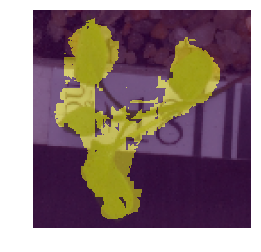

In [48]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

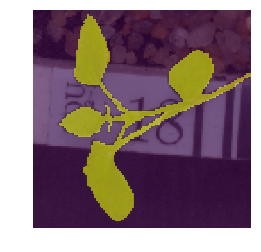

In [49]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## Fin

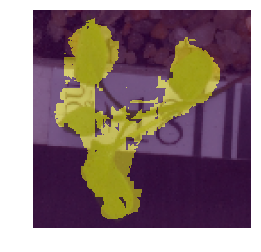

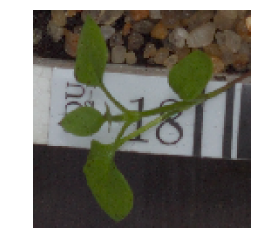

In [50]:
for (x,y) in iter(md.val_dl):
    py = to_np(learn.model(V(x)))
    ax = show_img(denorm(x)[0])
    show_img(py[0][0]>0, ax=ax, alpha=0.5);
    ax = show_img(denorm(x)[0])